In [132]:
from models import train_predict,CondensedGoogLeNet
from models.CNNModels import ResNet,CondensedAlexNet
from models.train_predict import get_confusion_matrix
from data.data_processing import generate_dummy_data,DataHandler,get_training_data_from_path
from config.hyperparams import GoogleNet_hyperparams,AlexNet_hyperparams
from backtest.backtest import Backtester


import tensorflow as tf
import pandas as pd
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
folder_for_samples = 'data/cnn_samples'

# Data Processing

## Get stock data in Handler object

In [138]:
# path_to_dump_samples = os.path.join(folder_for_samples,'regular')
path_to_dump_samples = os.path.join(folder_for_samples,'close-1_week-2015_2018-64_pixels-high_VOL')

handler = DataHandler(encoding_method='GADF', window_len=42, image_size=42, retrain_freq=5,
                 start_date = 20151101, end_date= 20161201, frac_of_stocks=0.01,
                stock_data_dir_path= 'data/2019_2010_stock_data',targets_methods=['close'],
                 dir_for_samples=path_to_dump_samples, nb_of_stocks_by_file=100,minimum_volume=3e6,
                      kwargs_target_methods = {'up_return':0.013,'down_return':-0.012,'buy_on_last_date':True}
                 )

In [139]:
handler.get_df_data()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

## Builds images and targets and creates pickles
+ Be careful for the folder name (specified in handler object), this function will delete all files in this folder before dumping pickles

In [140]:
handler.build_and_dump_images_and_targets()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

date
20151102         NaN
20151103         NaN
20151104         NaN
20151105         NaN
20151106    1.015015
20151109    0.996071
20151110    0.992796
20151111    0.991940
20151112    0.977777
20151113    0.963549
20151116    0.986473
20151117    0.985263
20151118    1.002934
20151119    1.017117
20151120    1.034895
20151123    1.018810
20151124    1.019370
20151125    1.004348
20151127    1.004574
20151130    0.995338
20151201    1.006019
20151202    0.996123
20151203    0.982576
20151204    1.002922
20151207    1.000620
20151208    0.983002
20151209    0.987026
20151210    1.006005
20151211    0.968109
20151214    0.980602
              ...   
20161020    1.003871
20161021    1.000609
20161024    1.007863
20161025    1.001602
20161026    0.999729
20161027    1.000940
20161028    1.000773
20161031    0.995659
20161101    0.992506
20161102    0.986687
20161103    0.986669
20161104    0.985388
20161107    1.006568
20161108    1.018099
20161109    1.036855
20161110    1.050360
20161111

C:\Users\elior illouz\Notebooks\Deep Learning\DeepLearningAllocationCNN\data\data_processing.py:306: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


date
20151102         NaN
20151103         NaN
20151104         NaN
20151105         NaN
20151106    1.010847
20151109    0.998024
20151110    0.969781
20151111    0.996229
20151112    0.970589
20151113    0.904830
20151116    0.894514
20151117    0.886036
20151118    0.912082
20151119    0.902324
20151120    0.952247
20151123    0.973128
20151124    1.026701
20151125    1.019790
20151127    1.026410
20151130    1.041626
20151201    1.019168
20151202    0.980019
20151203    0.979655
20151204    0.985387
20151207    0.972624
20151208    0.991073
20151209    0.995063
20151210    0.975909
20151211    0.967505
20151214    0.974533
              ...   
20161020    0.991213
20161021    1.003815
20161024    0.999746
20161025    0.995941
20161026    0.993426
20161027    0.974671
20161028    0.982767
20161031    0.986062
20161101    0.984971
20161102    0.977093
20161103    0.990384
20161104    0.984785
20161107    1.004112
20161108    0.982414
20161109    1.003125
20161110    1.049069
20161111

# Training

## Retrieve data from the specified folder
+ '/regular' is the default to retrieve samples
+ '/VWAP_1_week_2015_2017_all_stocks' is another one

In [3]:
%%time

# path_to_retrieve_samples = folder_for_samples+'/regular'
path_to_retrieve_samples = folder_for_samples+'/close-1_week-2015_2018-64_pixels-high_VOL'



X_train, X_val, X_test, Y_train, Y_val, Y_test = get_training_data_from_path(samples_path=path_to_retrieve_samples,
                                targets_type='close',
                                train_val_size=2 / 3.,
                                train_size=0.75,
                                logger_env='Training')


Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

Wall time: 4.9 s


## Build the neural network object and Train the network 
+ Choose your params BE CAREFUL about the path to drop the model_checkpoints
+ Choose or update hyperparameters
+ If you run restore = True Choose the checkpoint.meta file to use for the model to load

###### Then 

+ Choose parameters for the train_predict function 
+ Run the next cell to build the network object and train

In [125]:
X_train.shape

(9168, 42, 42, 5)

In [126]:
shape_x,shape_y = list(X_train.shape),list(Y_train.shape)
shape_x[0],shape_y[0] = None,None

GoogleNet_hyperparams.update({'learning_rate':0.003,'dropout':0.1})

# penalty factor assigned for misclassifying i to j. It used to combine sample prior (distribution of classes in the training
# sample) to compute expected penalty of misclassifying i-th class
cost_matrix=np.array([[0, 1.1, 1.4], [1.1, 0, 1.1], [1.4, 1.1, 0]])

n_test = 300
checkpoints_folder = 'model_checkpoints'
checkpoint_prefix = 'ckpt-close-1_week-2015_2018-64_pixels-high_VOL_cost_sensitive'
model_checkpoints_path = os.path.join(checkpoints_folder,checkpoint_prefix)

X_train1, X_val1, Y_train1, Y_val1 =  X_train[:n_test], X_val[:n_test], Y_train[:n_test], Y_val[:n_test]
# X_train1, X_val1, Y_train1, Y_val1 =  X_train[n_test:], X_val[:n_test], Y_train[n_test:], Y_val[:n_test]
# X_train1, X_val1, Y_train1, Y_val1 =  X_train, X_val, Y_train, Y_val



path_restore = (tf.train.latest_checkpoint('model_checkpoints') or '')+'.meta'

#### Run the training

In [129]:
# Googel
network = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)

# ResNet
# hyperparams = {'learning_rate':0.003,'tf_optimizer':'rmsprop','dropout':0.1}
# network = ResNet(shape_x=shape_x,shape_y=shape_y,hyperparams=hyperparams)

# AlexNet
# AlexNet_hyperparams.update({'learning_rate':0.003,'tf_optimizer':'adam','dropout':0.1})
# network = CondensedAlexNet(shape_x=shape_x,shape_y=shape_y,hyperparams=AlexNet_hyperparams)

In [131]:
GN_pred, GN_training_loss, GN_val_loss = train_predict(X=X_train1, Y=Y_train1, batch_size=30, valX=X_val1, valY=Y_val1,
                                                       model_ckpt_path=model_checkpoints_path, is_bayesian=True,cost_matrix=cost_matrix,
                                                       epochs=5, net=network,save_step =1,cost_sensitive_loss=True,restore=False,
                                                       model_ckpt_path_to_restore=path_restore)

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

0.000997781753540039 0.5637853145599365 0.000997781753540039
0.001995086669921875 0.33739519119262695 0.0009970664978027344
0.001995086669921875 0.32413363456726074 0.0
0.0019943714141845703 0.31120991706848145 0.0
0.0 0.3101065158843994 0.0
0.009991645812988281 0.3137068748474121 0.0
0.0 0.3097052574157715 0.0
0.0 0.30670833587646484 0.0
0.0 0.3198261260986328 0.0035076141357421875
0.0 0.3065683841705322 0.0
0.0009968280792236328 0.33065128326416016 0.0009970664978027344
0.0009989738464355469 0.36852025985717773 0.0019965171813964844
0.001993417739868164 0.33611059188842773 0.0
0.007139444351196289 0.31287312507629395 0.0
0.005915403366088867 0.3325324058532715 0.0009984970092773438
0.0019948482513427734 0.327181339263916 0.0009970664978027344
0.0009975433349609375 0.3381378650665283 0.0009963512420654297
0.0019953250885009766 0.32828664779663086 0.003507852554321289
0.002208232879638672 0.3133053779602051 0.0
0.006814479827880859 0.3037140369415283 0.0
0.0 0.31020307540893555 0.00989

KeyboardInterrupt: 

In [23]:
cf = get_confusion_matrix(Y_val1,GN_pred)
np.trace(cf)/np.sum(cf)

0.34671612480907704

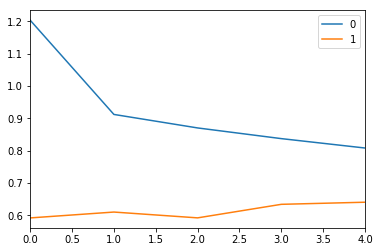

In [20]:
pd.DataFrame([GN_training_loss,GN_val_loss]).T.plot()

# Backtest

In [31]:
# to retrieve model
checkpoints_folder = 'model_checkpoints'
checkpoint_prefix = 'ckpt-close-1_week-2015_2018-64_pixels-high_VOL'
model_checkpoints_path = os.path.join(checkpoints_folder,checkpoint_prefix)
model_checkpoints_path_file = model_checkpoints_path+'-916.meta'


# to retrieve data
path_to_retrieve_samples = folder_for_samples+'/close-1_week-2015_2018-64_pixels-high_VOL'



backtester = Backtester(path_data=path_to_retrieve_samples,path_model_to_restore=model_checkpoints_path_file,start_date=20181101,end_date=20200609)

In [32]:
backtester.run_backtest()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model_checkpoints\ckpt-close-1_week-2015_2018-64_pixels-high_VOL-50


In [37]:
backtester.plot_backtest()

In [35]:
tmp

In [45]:
backtester.df_strats

,10_max_long,20_max_long,2_max_long,Cash
date,,,,
2015-04-13,1.004381,1.010277,1.071072,1.000000
2015-04-20,1.053073,1.045204,1.103819,1.003809
2015-04-27,1.045969,1.051027,1.084050,1.007881
2015-05-04,1.062162,1.083221,1.109006,1.010543
2015-05-11,1.073787,1.081304,1.134837,1.006165
2015-05-18,1.091121,1.099712,1.149497,1.017573
2015-05-26,1.065991,1.082422,1.143455,1.005625
2015-06-02,1.074504,1.093968,1.173525,1.008206
2015-06-09,1.057340,1.075251,1.112863,0.994131


In [7]:
backtester._df_permnos_to_buy = backtester._df_permnos_to_buy.shift(-1)

In [8]:
backtester._df_permnos_to_buy = backtester._df_permnos_to_buy.dropna()

In [9]:
strategies = ['10_max_long', '20_max_long', '2_max_long']

df_rets = backtester._df_all_data[['RET', 'PERMNO']].pivot_table(columns='PERMNO', index='date')
df_rets = df_rets.dropna().RET

# Run the backtest with the returns and the predictions
backtester.log('Running Backtest')
df_results = pd.DataFrame(columns=strategies, index=backtester._df_permnos_to_buy.index)
for date in backtester._df_permnos_to_buy.index:
    for strat in strategies:
        list_permnos_to_buy = backtester._df_permnos_to_buy.loc[date][strat]
        df_results.loc[date][strat] = df_rets.loc[date][list_permnos_to_buy].mean()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

In [11]:
from utils import integer_to_timestamp_date_index

df_strats = df_results.astype(np.float64)
df_strats = integer_to_timestamp_date_index(df_strats)
# df_strats['Cash'] = 1.03**(5./252.)
df_strats = df_strats.cumprod()

# we get SPX data and add it to the dataframe
df_spx = pd.read_csv('data/^GSPC.csv', index_col=0, usecols=['Date', 'Close'])
df_spx.index.name = 'date'
df_spx.columns = ['Cash'] # Columns that will be used to compute sharpe ratio
df_spx.index = pd.to_datetime(df_spx.index)
df_strats = pd.merge(df_strats, df_spx, how='left', on='date')
df_strats['Cash'] = df_strats['Cash']/df_strats['Cash'].iloc[0]


backtester.df_strats = df_strats

In [15]:
backtester.plot_backtest()

# Little tests section

In [69]:
df_raw = pd.read_csv('data/376d87b5fe8c8a7a.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [70]:
df_raw.head()

,PERMNO,date,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,sprtrn
0,10001,20100104,EGAS,ENERGY INC,10.10,10.5800,10.25,18500.0,-0.004854,4361.0,0.016043
1,10001,20100105,EGAS,ENERGY INC,9.80,10.3600,10.19,23200.0,-0.005854,4361.0,0.003116
2,10001,20100106,EGAS,ENERGY INC,10.15,10.4800,10.31,18700.0,0.011776,4361.0,0.000546
3,10001,20100107,EGAS,ENERGY INC,9.91,10.3695,9.96,29200.0,-0.033948,4361.0,0.004001
4,10001,20100108,EGAS,ENERGY INC,10.00,10.4000,10.34,25100.0,0.038153,4361.0,0.002882


In [117]:
len(df_raw.date.unique())

2264

In [118]:
df2 = df_raw.groupby('PERMNO').count()
len(df2[df2.VOL==2264])

3730

In [93]:
df_raw.values[0,0]

KeyboardInterrupt: 

In [98]:
c=0
for e in df_raw.RET:
    try:
        float(e)
    except:
        c+=1
        print(e)


C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


In [102]:
len(df_raw)/c

149.42074371366928

In [91]:
npdf_raw.RET.astype(float,errors='ignore')

TypeError: '<=' not supported between instances of 'str' and 'int'

In [112]:
len(list(set(df_raw.dropna().PERMNO)))

11424

In [109]:
len(list(set(df_raw.TICKER)))

11892

In [107]:
len(list(set(df_raw[df_raw.RET=='B'].PERMNO)))

148

In [116]:
len(set(handler._df_raw_data.index))

3307

In [71]:
df_aapl = df_raw[df_raw.TICKER=='AAPL'].set_index('date')

In [75]:
df_aapl.loc[20150331:20150417]

,PERMNO,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,sprtrn
date,,,,,,,,,,
20150331,14593,AAPL,APPLE INC,124.355,126.49000,124.43,42304683.0,-0.015352,5824748.0,-0.008796
20150401,14593,AAPL,APPLE INC,123.100,125.12000,124.25,40616873.0,-0.001447,5824748.0,-0.003965
20150402,14593,AAPL,APPLE INC,124.190,125.56000,125.32,32220148.0,0.008612,5824748.0,0.003530
20150406,14593,AAPL,APPLE INC,124.330,127.51000,127.35,37194209.0,0.016199,5824748.0,0.006609
20150407,14593,AAPL,APPLE INC,125.980,128.12180,126.01,35013481.0,-0.010522,5824748.0,-0.002062
20150408,14593,AAPL,APPLE INC,124.970,126.40000,125.60,37329257.0,-0.003254,5824748.0,0.002683
20150409,14593,AAPL,APPLE INC,124.660,126.58000,126.56,32483983.0,0.007643,5824748.0,0.004457
20150410,14593,AAPL,APPLE INC,125.260,127.21000,127.10,40195446.0,0.004267,5762278.0,0.005203
20150413,14593,AAPL,APPLE INC,126.610,128.57001,126.85,36365135.0,-0.001967,5762278.0,-0.004581


In [76]:
df_aapl.loc[20140601:20140615]

,PERMNO,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,sprtrn
date,,,,,,,,,,
20140602,14593,AAPL,APPLE INC,622.50000,634.83002,628.65002,13215942.0,-0.006872,861381.0,0.000728
20140603,14593,AAPL,APPLE INC,628.25000,638.73999,637.53998,10461660.0,0.014141,861381.0,-0.000379
20140604,14593,AAPL,APPLE INC,636.10999,647.89001,644.82001,11982292.0,0.011419,861381.0,0.001892
20140605,14593,AAPL,APPLE INC,642.60999,649.36987,647.34998,10850163.0,0.003924,861381.0,0.006525
20140606,14593,AAPL,APPLE INC,644.46997,651.26001,645.57001,12518493.0,-0.002750,861381.0,0.004628
20140609,14593,AAPL,APPLE INC,91.75000,93.88000,93.70000,75435857.0,0.016001,6029667.0,0.000939
20140610,14593,AAPL,APPLE INC,93.57000,95.05000,94.25000,62777132.0,0.005870,6029667.0,-0.000246
20140611,14593,AAPL,APPLE INC,93.47000,94.76000,93.86000,45698735.0,-0.004138,6029667.0,-0.003537
20140612,14593,AAPL,APPLE INC,91.90000,94.12000,92.29000,54748851.0,-0.016727,6029667.0,-0.007089


In [6]:
12518493/861381.0

14.533049835090395

In [7]:
75435857/6029667.0

12.510783265477182

In [73]:
df_aapl[df_split_stock!=0][35:75]

,PERMNO,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,sprtrn
date,,,,,,,,,,
20131226,14593,AAPL,APPLE INC,563.37598,569.50000,563.90002,7251755.0,-0.006641,892551.0,0.004745
20131227,14593,AAPL,APPLE INC,559.50000,564.40997,560.09003,8031150.0,-0.006757,892447.0,-0.000337
20140110,14593,AAPL,APPLE INC,531.10999,540.79999,532.94000,10839168.0,-0.006671,891989.0,0.002307
20140328,14593,AAPL,APPLE INC,534.25000,538.93988,536.85999,7163009.0,-0.001116,861745.0,0.004640
20140411,14593,AAPL,APPLE INC,517.14001,522.83002,519.60999,9714154.0,-0.007393,861381.0,-0.009487
20140609,14593,AAPL,APPLE INC,91.75000,93.88000,93.70000,75435857.0,0.016001,6029667.0,0.000939
20140627,14593,AAPL,APPLE INC,90.77000,92.00000,91.98000,64086742.0,0.011881,5989171.0,0.001911
20140711,14593,AAPL,APPLE INC,94.86250,95.89000,95.22000,34040197.0,0.001947,5987867.0,0.001471
20140926,14593,AAPL,APPLE INC,98.40000,100.75000,100.75000,62386930.0,0.029427,5866161.0,0.008576


In [72]:
df_split_stock = df_aapl.SHROUT.shift(1)-df_aapl.SHROUT
df_split_stock.to_frame()

,SHROUT
date,
20100104,NaN
20100105,0.0
20100106,0.0
20100107,0.0
20100108,0.0
20100111,0.0
20100112,0.0
20100113,0.0
20100114,0.0


In [ ]:
import tensorflow as tf

In [ ]:
tf.train.latest_checkpoint('model_checkpoints')

In [ ]:

# with tf.variable_scope('test',reuse=tf.AUTO_REUSE):
#     network2 = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)
#     network2.build_operations()
sess=tf.Session()    
#First let's load meta graph and restore weights
# saver = tf.train.import_meta_graph('model_checkpoints/ckpt1-266.meta')
saver = tf.train.import_meta_graph('model_checkpoints/ckpt-26.meta')
saver.restore(sess,tf.train.latest_checkpoint('model_checkpoints'))

In [ ]:
graph = tf.get_default_graph()
# w1 = graph.get_tensor_by_name("w1:0")
# w2 = graph.get_tensor_by_name("w2:0")
# feed_dict ={w1:13.0,w2:17.0}



+ CondensedGoogLeNet/loss/Mean gets the loss
+ CondensedGoogLeNet/Adam gets the optimizer
+ CondensedGoogLeNet/accuracy/Mean gets the accuracy
    + we can get the validation error just after
+ CondensedGoogLeNet/Merge/MergeSummary gets the summary op
+ CondensedGoogLeNet/init gets init_op
+ 

In [ ]:
output = graph.get_tensor_by_name('CondensedGoogLeNet/output:0')
train_op = graph.get_tensor_by_name('CondensedGoogLeNet/minimize:0')
x = graph.get_tensor_by_name('CondensedGoogLeNet/x:0')
y = graph.get_tensor_by_name('CondensedGoogLeNet/y:0')
global_step = graph.get_tensor_by_name('CondensedGoogLeNet/global_step:0')
# loss = graph.get_tensor_by_name('CondensedGoogLeNet/loss/Mean:0')

In [ ]:
pred = sess.run([train_op,global_step],feed_dict={x:X_val[:100],y:Y_val[:100]})

In [ ]:
pred

In [ ]:
network.optimizer

In [ ]:
# train_op = graph.get_tensor_by_name('CondensedGoogLeNet/minimize:0')


In [ ]:
train_op

In [ ]:
pred

In [ ]:
pred = sess.run(output,feed_dict={x:X_val1[:15]})
pred

In [ ]:
saver.save(sess,'model_checkpoints/test_restore')

In [ ]:
pd.DataFrame(np.max(pred,axis=1)).hist(bins=100)

In [ ]:
pred[:5]

In [ ]:
GN_pred[:5]

In [ ]:
Y_val[:5]

In [ ]:
pred.shape

In [ ]:
tf.reset_default_graph()

# Create some variables.
v1 = tf.get_variable("v1", shape=[3])
v2 = tf.get_variable("v2", shape=[5])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "/tmp/model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  print("v1 : %s" % v1.eval())
  print("v2 : %s" % v2.eval())

In [ ]:
tf.train.latest_checkpoint

In [ ]:
tf.train.import_meta_graph